# Strategie ewolucyjne

Notebook pokazuje podstawowe mechanizmy strategii ewolucyjnych.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import math

from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm

%matplotlib inline

In [2]:
def gen_points(start_point, angles, lengths):
    n = len(angles)
    xs = np.zeros(n+1)
    ys = np.zeros(n+1)
    xs[0] = start_point[0]
    ys[0] = start_point[1]
    last_angle = 0
    for i in range(n):
        angle = ((last_angle + 180 - angles[i])  + 180) % 360 - 180
        xs[i+1] = xs[i] + lengths[i] * math.sin(math.radians(angle))
        ys[i+1] = ys[i] + lengths[i] * math.cos(math.radians(angle))
        last_angle = angle
    return xs, ys

In [3]:
def objective_function(angles, lengths, start_point, target, ranges=None, penalty=None):
    if penalty is None:
        penalty = np.sum(lengths) * 1000

    score = 0
    n = len(angles)
    if ranges is not None:
        for i in range(n):
            if (angles[i] + 180) % 360 - 180 < ranges[i, 0] or (angles[i] + 180) % 360 - 180 > ranges[i, 1]:
                score -= penalty
    xs, ys = gen_points(start_point, angles, lengths)
    score -= np.sqrt((target[0] - xs[-1])**2 + (target[1] - ys[-1])**2)
    return score

In [42]:
def plot_path(start_point, angles, lengths):
    xs, ys = gen_points(start_point, angles, lengths)
    print(xs, ys, - np.sqrt((target[0] - xs[-1])**2 + (target[1] - ys[-1])**2))
    plt.plot(xs, ys)
    plt.show()

In [31]:
def es(objective_function, chromosome_length, population_size, number_of_iterations, number_of_offspring, 
       number_of_parents, sigma, tau, tau_0, ranges=None, log_frequency=1):

    mins = []
    maxs = []
    if ranges is not None:
        mins = ranges[:, 0].reshape(-1, 1)
        maxs = ranges[:, 1].reshape(-1, 1)
    
    best_solution = np.empty((1, chromosome_length))
    best_solution_objective_value = 0.00

    log_objective_values = np.empty((number_of_iterations, 4))
    log_best_solutions = np.empty((number_of_iterations, chromosome_length))
    log_best_sigmas = np.empty((number_of_iterations, chromosome_length))

    # generating an initial population
    current_population_solutions = 90.0 * np.random.rand(population_size, chromosome_length)
    current_population_sigmas = sigma * np.ones((population_size, chromosome_length))
    
    if ranges is not None:
        current_population_solutions = np.clip(current_population_solutions.T, mins, maxs).T
    
    current_population_objective_values = np.empty(population_size)
    children_population_objective_values = np.empty(number_of_offspring)
    # evaluating the objective function on the current population
    for i in range(population_size):
        current_population_objective_values[i] = objective_function(current_population_solutions[i, :])
#     current_population_objective_values = objective_function(current_population_solutions)

    for t in range(number_of_iterations):

        # selecting the parent indices by the roulette wheel method
        fitness_values = current_population_objective_values - current_population_objective_values.min()
        if fitness_values.sum() > 0:
            fitness_values = fitness_values / fitness_values.sum()
        else:
            fitness_values = 1.0 / population_size * np.ones(population_size)
        parent_indices = np.random.choice(population_size, (number_of_offspring, number_of_parents), True, fitness_values).astype(np.int64)

        # creating the children population by Global Intermediere Recombination
        children_population_solutions = np.zeros((number_of_offspring, chromosome_length))
        children_population_sigmas = np.zeros((number_of_offspring, chromosome_length))
        for i in range(number_of_offspring):
            children_population_solutions[i, :] = current_population_solutions[parent_indices[i, :], :].mean(axis=0)
            children_population_sigmas[i, :] = current_population_sigmas[parent_indices[i, :], :].mean(axis=0)

        # mutating the children population by adding random gaussian noise
        children_population_sigmas = children_population_sigmas * np.exp(tau * np.random.randn(number_of_offspring, chromosome_length) + tau_0 * np.random.randn(number_of_offspring, 1))
        children_population_solutions = children_population_solutions + children_population_sigmas * np.random.randn(number_of_offspring, chromosome_length)
        
        if ranges is not None:
            children_population_solutions = np.clip(children_population_solutions.T, mins, maxs).T
        
        # evaluating the objective function on the children population
        for i in range(number_of_offspring):
            children_population_objective_values[i] = objective_function(current_population_solutions[i, :])
#         children_population_objective_values = objective_function(children_population_solutions)

        # replacing the current population by (Mu + Lambda) Replacement
        current_population_objective_values = np.hstack([current_population_objective_values, children_population_objective_values])
        current_population_solutions = np.vstack([current_population_solutions, children_population_solutions])
        current_population_sigmas = np.vstack([current_population_sigmas, children_population_sigmas])

        I = np.argsort(current_population_objective_values)[::-1]
        current_population_solutions = current_population_solutions[I[:population_size], :]
        current_population_sigmas = current_population_sigmas[I[:population_size], :]
        current_population_objective_values = current_population_objective_values[I[:population_size]]
#         print(current_population_objective_values)

        # recording some statistics
        if best_solution_objective_value < current_population_objective_values[0]:
            best_solution = current_population_solutions[0, :]
            best_solution_objective_value = current_population_objective_values[0]
        log_objective_values[t, :] = [current_population_objective_values.min(), current_population_objective_values.max(), current_population_objective_values.mean(), current_population_objective_values.std()]
        log_best_solutions[t, :] = current_population_solutions[0, :]
        log_best_sigmas[t, :] = current_population_sigmas[0, :]

        if np.mod(t, log_frequency) == 0:
            print("Iteration %04d : best score = %0.8f, mean score = %0.8f." % (t, log_objective_values[:t+1, 1].max(), log_objective_values[t, 2]))

    return best_solution_objective_value, best_solution, log_objective_values, log_best_solutions, log_best_sigmas

In [41]:
np.array([0, 0])[0]

0

In [32]:
d = 20
N = 800
T = 800
start_point = np.array([0, 0])
target = np.array([10, 20])
ranges = np.array([[-180, 180]]*d)
lengths = np.array([1,3] * (d//2))
n_of_p = 2
sigma = 40
k = 1.0
tau = k/np.sqrt(2*d)
tau_0 = k/np.sqrt(2*np.sqrt(d))

best_solution_objective_value, best_solution, history_objective_values, history_best_chromosome, history_best_sigmas = es(
    lambda x: objective_function(x, lengths, start_point, target, ranges=ranges, penalty=None), 
    d, 2*N, T, N, n_of_p, sigma, tau, tau_0, ranges=ranges, log_frequency=50)

Iteration 0000 : best score = -15.66842784, mean score = -22.61721348.
Iteration 0050 : best score = -2.54380558, mean score = -12.01762064.
Iteration 0100 : best score = -2.54380558, mean score = -10.26639759.
Iteration 0150 : best score = -2.54380558, mean score = -9.49249962.
Iteration 0200 : best score = -2.44159700, mean score = -8.54100013.
Iteration 0250 : best score = -2.44159700, mean score = -7.63520846.
Iteration 0300 : best score = -2.44159700, mean score = -7.00289252.
Iteration 0350 : best score = -0.32121232, mean score = -6.38174189.
Iteration 0400 : best score = -0.32121232, mean score = -5.56626095.
Iteration 0450 : best score = -0.32121232, mean score = -5.03564675.
Iteration 0500 : best score = -0.32121232, mean score = -4.54010911.
Iteration 0550 : best score = -0.32121232, mean score = -4.07766516.
Iteration 0600 : best score = -0.32121232, mean score = -3.77993626.
Iteration 0650 : best score = -0.32121232, mean score = -3.51994065.
Iteration 0700 : best score = 

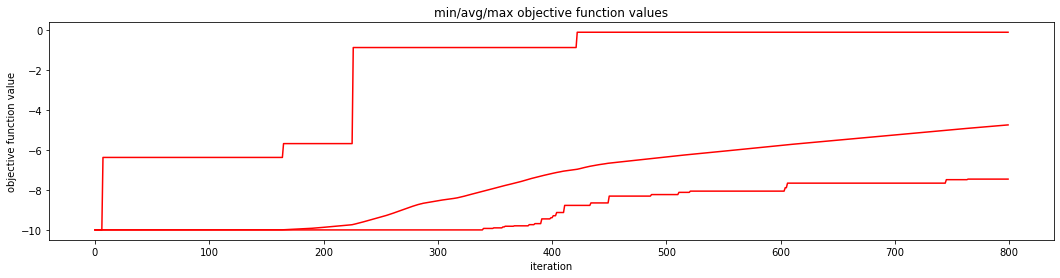

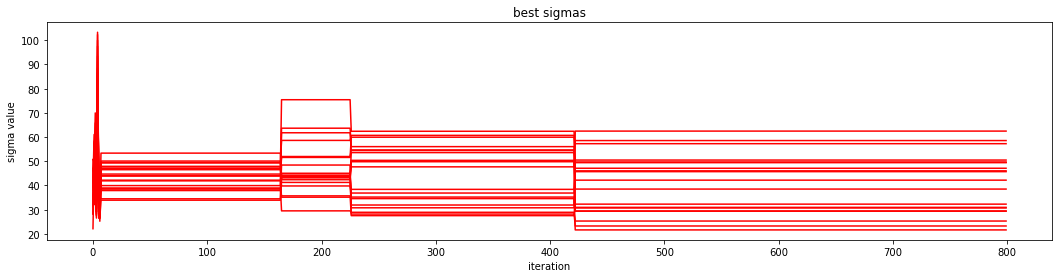

In [30]:
plt.figure(figsize=(18, 4))
plt.plot(history_objective_values[:, 0], 'r-')
plt.plot(history_objective_values[:, 1], 'r-')
plt.plot(history_objective_values[:, 2], 'r-')
plt.xlabel('iteration')
plt.ylabel('objective function value')
plt.title('min/avg/max objective function values')
plt.show()

plt.figure(figsize=(18, 4))
plt.plot(history_best_sigmas, 'r-')
plt.xlabel('iteration')
plt.ylabel('sigma value')
plt.title('best sigmas')
plt.show()

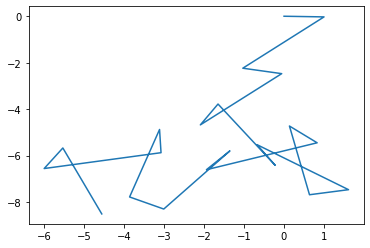

In [33]:
for i in range(0, T, 100):
    plot_path(start_point, history_best_chromosome[i, :], lengths)

In [35]:
d = 20
N = 800
T = 800
start_point = np.array([0, 0])
target = np.array([10, 20])
ranges = np.array([[-180, 180]]*d)
lengths = np.array([1,3] * (d//2))
n_of_p = 2
sigma = 40
k = 1.0
tau = k/np.sqrt(2*d)
tau_0 = k/np.sqrt(2*np.sqrt(d))

best_solution_objective_value, best_solution, history_objective_values, history_best_chromosome, history_best_sigmas = es(
    lambda x: objective_function(x, lengths, start_point, target, ranges=ranges, penalty=None), 
    d, 2*N, T, N, n_of_p, sigma, tau, tau_0, ranges=None, log_frequency=50)

Iteration 0000 : best score = -13.71853405, mean score = -22.56479024.
Iteration 0050 : best score = -5.14078650, mean score = -11.67990349.
Iteration 0100 : best score = -5.09874383, mean score = -10.08655281.
Iteration 0150 : best score = -5.09874383, mean score = -9.38192991.
Iteration 0200 : best score = -5.09874383, mean score = -8.89825071.
Iteration 0250 : best score = -5.09874383, mean score = -8.39831762.
Iteration 0300 : best score = -5.09874383, mean score = -7.86214052.
Iteration 0350 : best score = -5.09874383, mean score = -7.54724266.
Iteration 0400 : best score = -5.09874383, mean score = -7.24060167.
Iteration 0450 : best score = -5.09874383, mean score = -7.00205933.
Iteration 0500 : best score = -5.09874383, mean score = -6.85918431.
Iteration 0550 : best score = -5.09874383, mean score = -6.79996415.
Iteration 0600 : best score = -5.09874383, mean score = -6.75139097.
Iteration 0650 : best score = -5.09874383, mean score = -6.70704888.
Iteration 0700 : best score = 

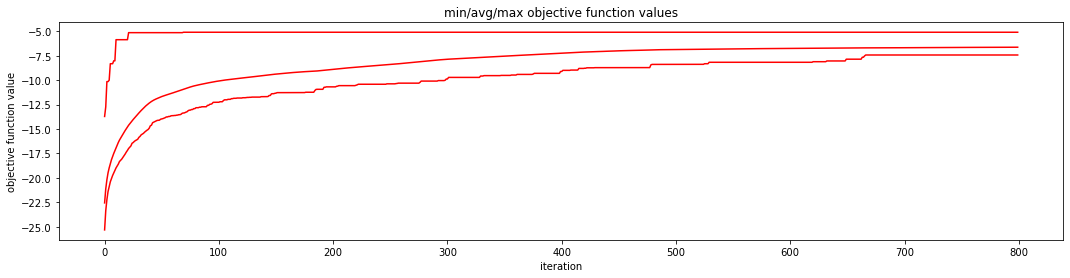

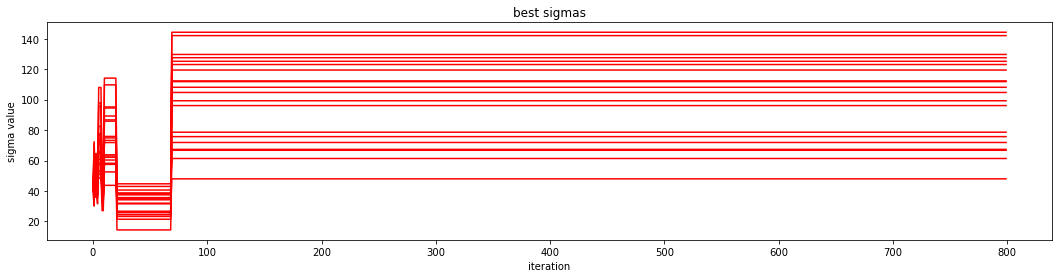

In [36]:
plt.figure(figsize=(18, 4))
plt.plot(history_objective_values[:, 0], 'r-')
plt.plot(history_objective_values[:, 1], 'r-')
plt.plot(history_objective_values[:, 2], 'r-')
plt.xlabel('iteration')
plt.ylabel('objective function value')
plt.title('min/avg/max objective function values')
plt.show()

plt.figure(figsize=(18, 4))
plt.plot(history_best_sigmas, 'r-')
plt.xlabel('iteration')
plt.ylabel('sigma value')
plt.title('best sigmas')
plt.show()

[ 0.          0.99835347 -2.00059737 -1.96038646  0.96548009 -0.01322545
  1.52500983  1.09776822  0.75143967  1.75123806 -0.56109944 -1.19284227
  1.26631005  0.35057984  3.34297755  2.40187704  4.70651091  4.37042205
  4.4083761   4.52837573  3.35931124] [ 0.         -0.05736165  0.02197229  1.02116351  0.3583627   0.15309348
  2.72871617  1.82457867  4.80452105  4.82460066  2.91329344  3.68847148
  1.97016712  2.37196083  2.58539934  2.24727237  4.16786154  3.22603126
  6.22579116  5.23301722  7.99585783] -13.718534050632138


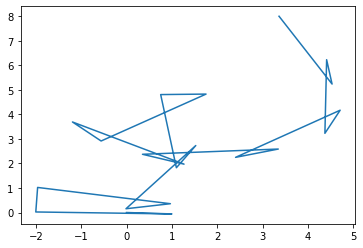

[ 0.          0.56712218 -2.13576339 -1.95526071  0.78568112 -0.18248037
 -0.3982525  -1.34682883 -1.61957611 -2.37498041 -4.96396381 -5.71647876
 -6.61202458 -6.0406338  -6.92343736 -6.92665644 -6.45766655 -7.45764934
 -4.74952316 -3.97388582 -1.69143805] [ 0.         -0.82363368 -2.12532858 -1.14175408 -2.36127771 -2.1109513
 -5.10318163 -5.41973015 -2.43215439 -1.7768954  -0.26125528  0.39731989
 -2.46589468 -3.28657281 -6.15374177 -5.15374695 -8.11686161 -8.11099568
 -6.8202391  -6.18906025 -8.13596348] -30.468379749332907


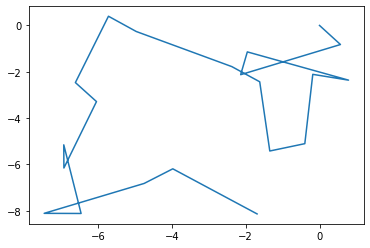

[ 0.          0.56712218 -2.13576339 -1.95526071  0.78568112 -0.18248037
 -0.3982525  -1.34682883 -1.61957611 -2.37498041 -4.96396381 -5.71647876
 -6.61202458 -6.0406338  -6.92343736 -6.92665644 -6.45766655 -7.45764934
 -4.74952316 -3.97388582 -1.69143805] [ 0.         -0.82363368 -2.12532858 -1.14175408 -2.36127771 -2.1109513
 -5.10318163 -5.41973015 -2.43215439 -1.7768954  -0.26125528  0.39731989
 -2.46589468 -3.28657281 -6.15374177 -5.15374695 -8.11686161 -8.11099568
 -6.8202391  -6.18906025 -8.13596348] -30.468379749332907


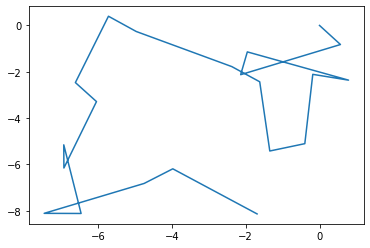

[ 0.          0.56712218 -2.13576339 -1.95526071  0.78568112 -0.18248037
 -0.3982525  -1.34682883 -1.61957611 -2.37498041 -4.96396381 -5.71647876
 -6.61202458 -6.0406338  -6.92343736 -6.92665644 -6.45766655 -7.45764934
 -4.74952316 -3.97388582 -1.69143805] [ 0.         -0.82363368 -2.12532858 -1.14175408 -2.36127771 -2.1109513
 -5.10318163 -5.41973015 -2.43215439 -1.7768954  -0.26125528  0.39731989
 -2.46589468 -3.28657281 -6.15374177 -5.15374695 -8.11686161 -8.11099568
 -6.8202391  -6.18906025 -8.13596348] -30.468379749332907


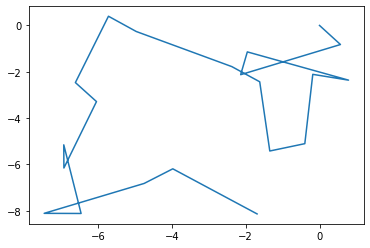

[ 0.          0.56712218 -2.13576339 -1.95526071  0.78568112 -0.18248037
 -0.3982525  -1.34682883 -1.61957611 -2.37498041 -4.96396381 -5.71647876
 -6.61202458 -6.0406338  -6.92343736 -6.92665644 -6.45766655 -7.45764934
 -4.74952316 -3.97388582 -1.69143805] [ 0.         -0.82363368 -2.12532858 -1.14175408 -2.36127771 -2.1109513
 -5.10318163 -5.41973015 -2.43215439 -1.7768954  -0.26125528  0.39731989
 -2.46589468 -3.28657281 -6.15374177 -5.15374695 -8.11686161 -8.11099568
 -6.8202391  -6.18906025 -8.13596348] -30.468379749332907


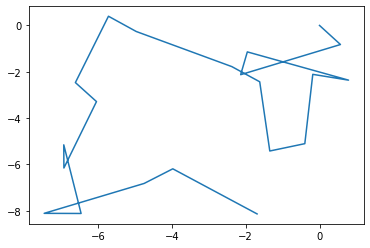

[ 0.          0.56712218 -2.13576339 -1.95526071  0.78568112 -0.18248037
 -0.3982525  -1.34682883 -1.61957611 -2.37498041 -4.96396381 -5.71647876
 -6.61202458 -6.0406338  -6.92343736 -6.92665644 -6.45766655 -7.45764934
 -4.74952316 -3.97388582 -1.69143805] [ 0.         -0.82363368 -2.12532858 -1.14175408 -2.36127771 -2.1109513
 -5.10318163 -5.41973015 -2.43215439 -1.7768954  -0.26125528  0.39731989
 -2.46589468 -3.28657281 -6.15374177 -5.15374695 -8.11686161 -8.11099568
 -6.8202391  -6.18906025 -8.13596348] -30.468379749332907


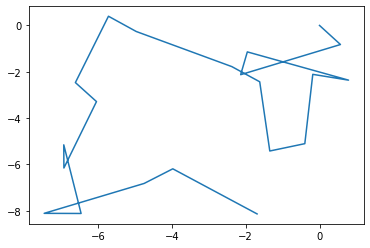

[ 0.          0.56712218 -2.13576339 -1.95526071  0.78568112 -0.18248037
 -0.3982525  -1.34682883 -1.61957611 -2.37498041 -4.96396381 -5.71647876
 -6.61202458 -6.0406338  -6.92343736 -6.92665644 -6.45766655 -7.45764934
 -4.74952316 -3.97388582 -1.69143805] [ 0.         -0.82363368 -2.12532858 -1.14175408 -2.36127771 -2.1109513
 -5.10318163 -5.41973015 -2.43215439 -1.7768954  -0.26125528  0.39731989
 -2.46589468 -3.28657281 -6.15374177 -5.15374695 -8.11686161 -8.11099568
 -6.8202391  -6.18906025 -8.13596348] -30.468379749332907


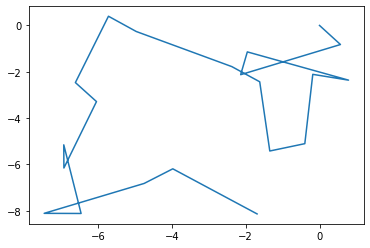

[ 0.          0.56712218 -2.13576339 -1.95526071  0.78568112 -0.18248037
 -0.3982525  -1.34682883 -1.61957611 -2.37498041 -4.96396381 -5.71647876
 -6.61202458 -6.0406338  -6.92343736 -6.92665644 -6.45766655 -7.45764934
 -4.74952316 -3.97388582 -1.69143805] [ 0.         -0.82363368 -2.12532858 -1.14175408 -2.36127771 -2.1109513
 -5.10318163 -5.41973015 -2.43215439 -1.7768954  -0.26125528  0.39731989
 -2.46589468 -3.28657281 -6.15374177 -5.15374695 -8.11686161 -8.11099568
 -6.8202391  -6.18906025 -8.13596348] -30.468379749332907


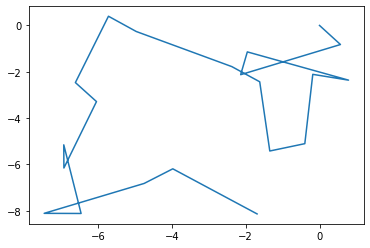

In [43]:
for i in range(0, T, 100):
    plot_path(start_point, history_best_chromosome[i, :], lengths)

In [44]:
d = 20
N = 800
T = 800
start_point = np.array([0, 0])
target = np.array([10, 20])
ranges = np.array([[-180, 180]]*d)
lengths = np.array([1,3] * (d//2))
n_of_p = 2
sigma = 10
k = 1.0
tau = k/np.sqrt(2*d)
tau_0 = k/np.sqrt(2*np.sqrt(d))

best_solution_objective_value, best_solution, history_objective_values, history_best_chromosome, history_best_sigmas = es(
    lambda x: objective_function(x, lengths, start_point, target, ranges=ranges, penalty=None), 
    d, 2*N, T, N, n_of_p, sigma, tau, tau_0, ranges=ranges, log_frequency=50)

Iteration 0000 : best score = -15.96192107, mean score = -22.70738305.
Iteration 0050 : best score = -12.72746159, mean score = -16.95049922.
Iteration 0100 : best score = -12.72746159, mean score = -16.43000739.
Iteration 0150 : best score = -12.72746159, mean score = -16.17458745.
Iteration 0200 : best score = -12.72746159, mean score = -15.95298882.
Iteration 0250 : best score = -12.72746159, mean score = -15.79596068.
Iteration 0300 : best score = -12.72746159, mean score = -15.71710644.
Iteration 0350 : best score = -12.72746159, mean score = -15.66096400.
Iteration 0400 : best score = -12.72746159, mean score = -15.61055442.
Iteration 0450 : best score = -12.72746159, mean score = -15.56385514.
Iteration 0500 : best score = -12.72746159, mean score = -15.52152189.
Iteration 0550 : best score = -12.72746159, mean score = -15.47918864.
Iteration 0600 : best score = -12.72746159, mean score = -15.43685538.
Iteration 0650 : best score = -12.72746159, mean score = -15.40367103.
Iterat

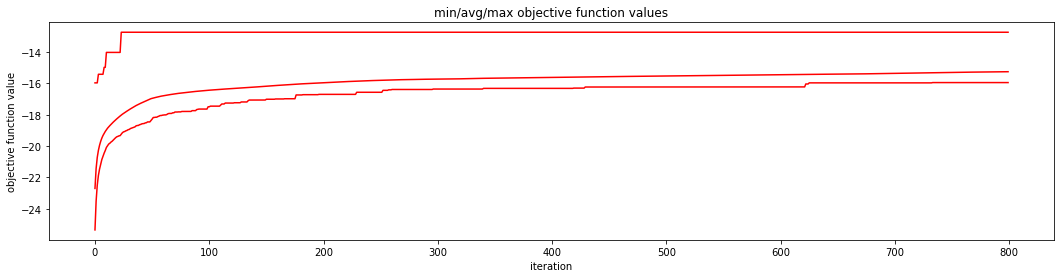

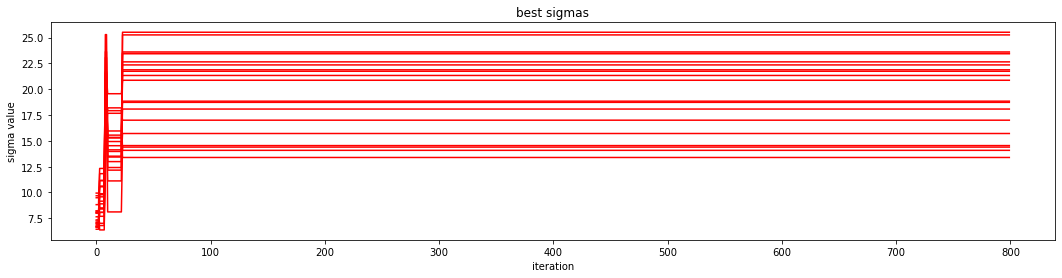

In [45]:
plt.figure(figsize=(18, 4))
plt.plot(history_objective_values[:, 0], 'r-')
plt.plot(history_objective_values[:, 1], 'r-')
plt.plot(history_objective_values[:, 2], 'r-')
plt.xlabel('iteration')
plt.ylabel('objective function value')
plt.title('min/avg/max objective function values')
plt.show()

plt.figure(figsize=(18, 4))
plt.plot(history_best_sigmas, 'r-')
plt.xlabel('iteration')
plt.ylabel('sigma value')
plt.title('best sigmas')
plt.show()

[ 0.          0.50309121 -2.49027888 -2.42509832  0.55990345  0.0711778
 -0.42877898  0.20383276 -2.24610812 -1.27422006 -1.34443295 -1.32489968
  0.44832248 -0.44716008  1.1917012   1.16393758 -0.35404477  0.35823846
 -2.64174993 -2.52140237 -1.51137916] [ 0.         -0.86423332 -1.06357109 -0.0656976  -0.36530467 -1.23774219
  1.720305    0.9458359   2.67724854  2.91269194 -0.0864863   0.9133229
 -1.50652899 -1.95162561  0.5611684  -0.43844611  2.14916467  1.44727251
  1.43892487  2.43165669 -0.39320669] -23.41782930679115


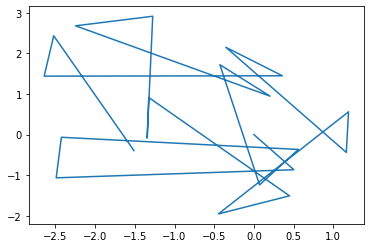

[ 0.          0.69137631 -1.93264491 -2.12667548  0.38210851 -0.37161307
 -0.37584104  0.48163022 -2.44199392 -1.78498851 -1.10462244 -1.7728017
  0.8020691  -0.18400796  2.15378617  1.9073188   1.92359692  2.89689681
  0.13097097 -0.11804103  1.82385783] [ 0.         -0.72249485 -2.17663125 -1.19563577 -2.84062904 -3.49782291
 -0.49782589 -1.01235775 -0.33973462  0.41415124 -2.50768072 -1.7636804
 -3.30317394 -3.13688493 -1.2568002  -2.22595129  0.77400455  0.54446736
 -0.61727884  0.35122155 -1.93548542] -23.409716392314817


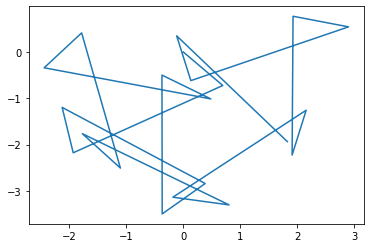

[ 0.          0.69137631 -1.93264491 -2.12667548  0.38210851 -0.37161307
 -0.37584104  0.48163022 -2.44199392 -1.78498851 -1.10462244 -1.7728017
  0.8020691  -0.18400796  2.15378617  1.9073188   1.92359692  2.89689681
  0.13097097 -0.11804103  1.82385783] [ 0.         -0.72249485 -2.17663125 -1.19563577 -2.84062904 -3.49782291
 -0.49782589 -1.01235775 -0.33973462  0.41415124 -2.50768072 -1.7636804
 -3.30317394 -3.13688493 -1.2568002  -2.22595129  0.77400455  0.54446736
 -0.61727884  0.35122155 -1.93548542] -23.409716392314817


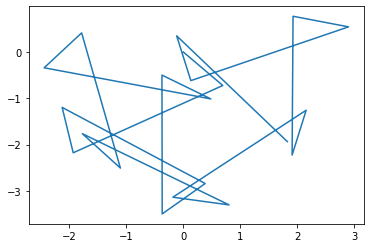

[ 0.          0.69137631 -1.93264491 -2.12667548  0.38210851 -0.37161307
 -0.37584104  0.48163022 -2.44199392 -1.78498851 -1.10462244 -1.7728017
  0.8020691  -0.18400796  2.15378617  1.9073188   1.92359692  2.89689681
  0.13097097 -0.11804103  1.82385783] [ 0.         -0.72249485 -2.17663125 -1.19563577 -2.84062904 -3.49782291
 -0.49782589 -1.01235775 -0.33973462  0.41415124 -2.50768072 -1.7636804
 -3.30317394 -3.13688493 -1.2568002  -2.22595129  0.77400455  0.54446736
 -0.61727884  0.35122155 -1.93548542] -23.409716392314817


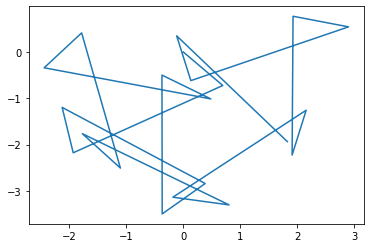

[ 0.          0.69137631 -1.93264491 -2.12667548  0.38210851 -0.37161307
 -0.37584104  0.48163022 -2.44199392 -1.78498851 -1.10462244 -1.7728017
  0.8020691  -0.18400796  2.15378617  1.9073188   1.92359692  2.89689681
  0.13097097 -0.11804103  1.82385783] [ 0.         -0.72249485 -2.17663125 -1.19563577 -2.84062904 -3.49782291
 -0.49782589 -1.01235775 -0.33973462  0.41415124 -2.50768072 -1.7636804
 -3.30317394 -3.13688493 -1.2568002  -2.22595129  0.77400455  0.54446736
 -0.61727884  0.35122155 -1.93548542] -23.409716392314817


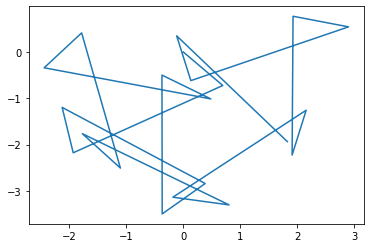

[ 0.          0.69137631 -1.93264491 -2.12667548  0.38210851 -0.37161307
 -0.37584104  0.48163022 -2.44199392 -1.78498851 -1.10462244 -1.7728017
  0.8020691  -0.18400796  2.15378617  1.9073188   1.92359692  2.89689681
  0.13097097 -0.11804103  1.82385783] [ 0.         -0.72249485 -2.17663125 -1.19563577 -2.84062904 -3.49782291
 -0.49782589 -1.01235775 -0.33973462  0.41415124 -2.50768072 -1.7636804
 -3.30317394 -3.13688493 -1.2568002  -2.22595129  0.77400455  0.54446736
 -0.61727884  0.35122155 -1.93548542] -23.409716392314817


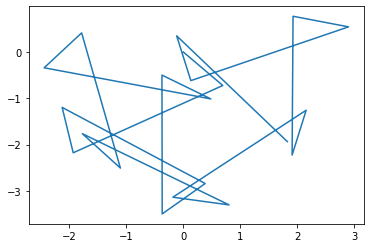

[ 0.          0.69137631 -1.93264491 -2.12667548  0.38210851 -0.37161307
 -0.37584104  0.48163022 -2.44199392 -1.78498851 -1.10462244 -1.7728017
  0.8020691  -0.18400796  2.15378617  1.9073188   1.92359692  2.89689681
  0.13097097 -0.11804103  1.82385783] [ 0.         -0.72249485 -2.17663125 -1.19563577 -2.84062904 -3.49782291
 -0.49782589 -1.01235775 -0.33973462  0.41415124 -2.50768072 -1.7636804
 -3.30317394 -3.13688493 -1.2568002  -2.22595129  0.77400455  0.54446736
 -0.61727884  0.35122155 -1.93548542] -23.409716392314817


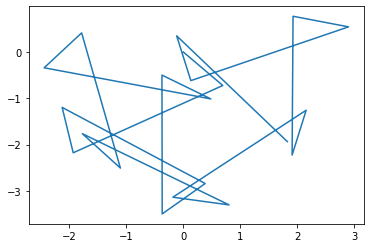

[ 0.          0.69137631 -1.93264491 -2.12667548  0.38210851 -0.37161307
 -0.37584104  0.48163022 -2.44199392 -1.78498851 -1.10462244 -1.7728017
  0.8020691  -0.18400796  2.15378617  1.9073188   1.92359692  2.89689681
  0.13097097 -0.11804103  1.82385783] [ 0.         -0.72249485 -2.17663125 -1.19563577 -2.84062904 -3.49782291
 -0.49782589 -1.01235775 -0.33973462  0.41415124 -2.50768072 -1.7636804
 -3.30317394 -3.13688493 -1.2568002  -2.22595129  0.77400455  0.54446736
 -0.61727884  0.35122155 -1.93548542] -23.409716392314817


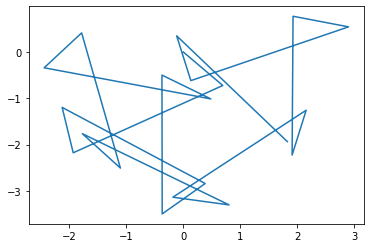

In [46]:
for i in range(0, T, 100):
    plot_path(start_point, history_best_chromosome[i, :], lengths)

In [50]:
d = 20
N = 800
T = 800
start_point = np.array([0, 0])
target = np.array([10, 20])
ranges = np.array([[-180, 180]]*d)
lengths = np.array([1,3] * (d//2))
n_of_p = 1
sigma = 10
k = 1.0
tau = k/np.sqrt(2*d)
tau_0 = k/np.sqrt(2*np.sqrt(d))

best_solution_objective_value, best_solution, history_objective_values, history_best_chromosome, history_best_sigmas = es(
    lambda x: objective_function(x, lengths, start_point, target, ranges=ranges, penalty=None), 
    d, 2*N, T, N, n_of_p, sigma, tau, tau_0, ranges=ranges, log_frequency=50)

Iteration 0000 : best score = -15.06588032, mean score = -22.81884412.
Iteration 0050 : best score = -6.04211091, mean score = -15.18868866.
Iteration 0100 : best score = -6.04211091, mean score = -13.60494584.
Iteration 0150 : best score = -6.04211091, mean score = -13.15132567.
Iteration 0200 : best score = -6.04211091, mean score = -12.65008968.
Iteration 0250 : best score = -6.04211091, mean score = -12.10254073.
Iteration 0300 : best score = -6.04211091, mean score = -11.57368868.
Iteration 0350 : best score = -6.04211091, mean score = -11.09537315.
Iteration 0400 : best score = -6.04211091, mean score = -10.66311836.
Iteration 0450 : best score = -6.04211091, mean score = -10.24033364.
Iteration 0500 : best score = -6.04211091, mean score = -9.96297102.
Iteration 0550 : best score = -6.04211091, mean score = -9.72444879.
Iteration 0600 : best score = -6.04211091, mean score = -9.50612547.
Iteration 0650 : best score = -5.43520281, mean score = -9.26142783.
Iteration 0700 : best s

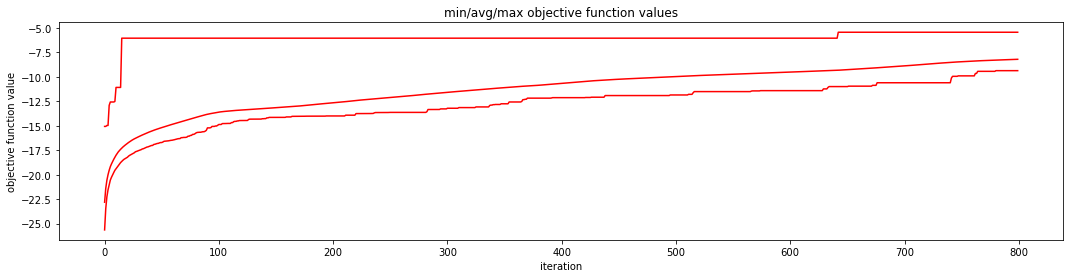

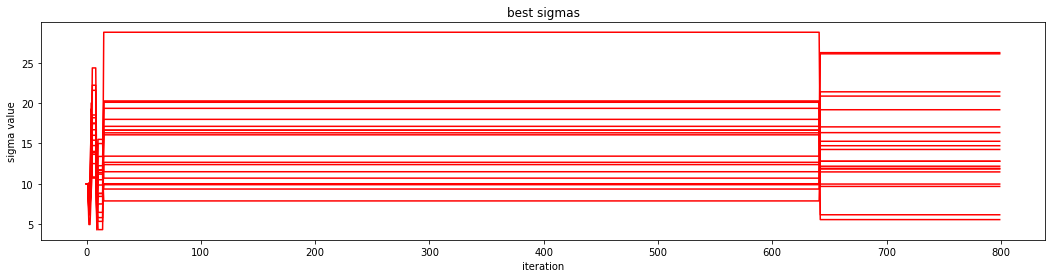

In [51]:
plt.figure(figsize=(18, 4))
plt.plot(history_objective_values[:, 0], 'r-')
plt.plot(history_objective_values[:, 1], 'r-')
plt.plot(history_objective_values[:, 2], 'r-')
plt.xlabel('iteration')
plt.ylabel('objective function value')
plt.title('min/avg/max objective function values')
plt.show()

plt.figure(figsize=(18, 4))
plt.plot(history_best_sigmas, 'r-')
plt.xlabel('iteration')
plt.ylabel('sigma value')
plt.title('best sigmas')
plt.show()

[ 0.          0.20506901 -1.49957424 -0.51186857 -2.77248076 -3.02779006
 -0.14144026 -1.13157008  1.49515733  0.75818781  2.91917743  3.01456398
  2.31231462  2.919418   -0.03756679  0.42933921  2.99053257  2.03301709
  5.03256879  4.04159094  5.3242164 ] [ 0.         -0.97874752  1.48989409  1.64621914 -0.325996    0.64086343
 -0.17705151 -0.03689823  1.41234402  0.73641804  2.81731301  1.8218727
  4.73852246  3.9438996   3.4376971   4.32200406  2.75986176  3.04824363
  3.1001049   2.96607914  5.67806585] -15.06588032485452


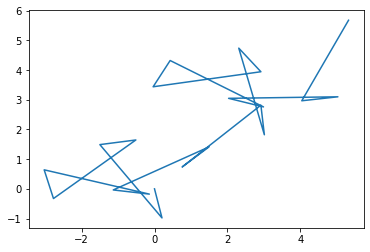

[ 0.          0.5390585  -2.45219603 -1.91269411 -2.93766074 -3.63983154
 -1.1081876  -1.86396004 -0.04128738  0.93663285  0.21623997  0.8217262
  0.25254386 -0.04055041  2.75443128  1.75582254  1.55824874  1.35585742
 -1.40983269 -0.78103701 -1.33457425] [ 0.         -0.84226833 -1.0711708  -0.22918644 -3.04866217 -2.33665362
 -0.72706392 -1.38189826  1.00092871  1.20990722 -1.70231428 -0.9064585
 -3.85196889 -2.89588535 -3.98587494 -3.93314383 -0.9396568  -1.91896153
 -3.08126882 -2.30369825 -5.2521888 ] -27.679335481876468


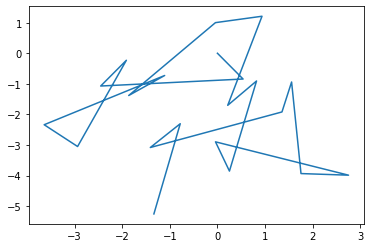

[ 0.          0.5390585  -2.45219603 -1.91269411 -2.93766074 -3.63983154
 -1.1081876  -1.86396004 -0.04128738  0.93663285  0.21623997  0.8217262
  0.25254386 -0.04055041  2.75443128  1.75582254  1.55824874  1.35585742
 -1.40983269 -0.78103701 -1.33457425] [ 0.         -0.84226833 -1.0711708  -0.22918644 -3.04866217 -2.33665362
 -0.72706392 -1.38189826  1.00092871  1.20990722 -1.70231428 -0.9064585
 -3.85196889 -2.89588535 -3.98587494 -3.93314383 -0.9396568  -1.91896153
 -3.08126882 -2.30369825 -5.2521888 ] -27.679335481876468


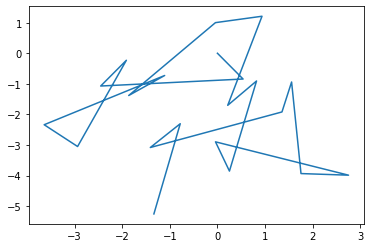

[ 0.          0.5390585  -2.45219603 -1.91269411 -2.93766074 -3.63983154
 -1.1081876  -1.86396004 -0.04128738  0.93663285  0.21623997  0.8217262
  0.25254386 -0.04055041  2.75443128  1.75582254  1.55824874  1.35585742
 -1.40983269 -0.78103701 -1.33457425] [ 0.         -0.84226833 -1.0711708  -0.22918644 -3.04866217 -2.33665362
 -0.72706392 -1.38189826  1.00092871  1.20990722 -1.70231428 -0.9064585
 -3.85196889 -2.89588535 -3.98587494 -3.93314383 -0.9396568  -1.91896153
 -3.08126882 -2.30369825 -5.2521888 ] -27.679335481876468


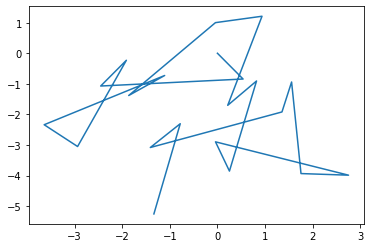

[ 0.          0.5390585  -2.45219603 -1.91269411 -2.93766074 -3.63983154
 -1.1081876  -1.86396004 -0.04128738  0.93663285  0.21623997  0.8217262
  0.25254386 -0.04055041  2.75443128  1.75582254  1.55824874  1.35585742
 -1.40983269 -0.78103701 -1.33457425] [ 0.         -0.84226833 -1.0711708  -0.22918644 -3.04866217 -2.33665362
 -0.72706392 -1.38189826  1.00092871  1.20990722 -1.70231428 -0.9064585
 -3.85196889 -2.89588535 -3.98587494 -3.93314383 -0.9396568  -1.91896153
 -3.08126882 -2.30369825 -5.2521888 ] -27.679335481876468


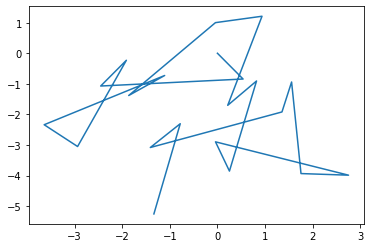

[ 0.          0.5390585  -2.45219603 -1.91269411 -2.93766074 -3.63983154
 -1.1081876  -1.86396004 -0.04128738  0.93663285  0.21623997  0.8217262
  0.25254386 -0.04055041  2.75443128  1.75582254  1.55824874  1.35585742
 -1.40983269 -0.78103701 -1.33457425] [ 0.         -0.84226833 -1.0711708  -0.22918644 -3.04866217 -2.33665362
 -0.72706392 -1.38189826  1.00092871  1.20990722 -1.70231428 -0.9064585
 -3.85196889 -2.89588535 -3.98587494 -3.93314383 -0.9396568  -1.91896153
 -3.08126882 -2.30369825 -5.2521888 ] -27.679335481876468


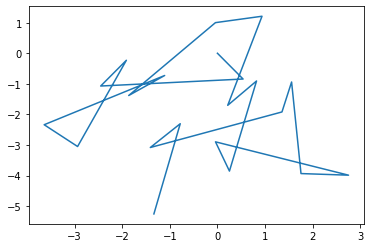

[ 0.          0.5390585  -2.45219603 -1.91269411 -2.93766074 -3.63983154
 -1.1081876  -1.86396004 -0.04128738  0.93663285  0.21623997  0.8217262
  0.25254386 -0.04055041  2.75443128  1.75582254  1.55824874  1.35585742
 -1.40983269 -0.78103701 -1.33457425] [ 0.         -0.84226833 -1.0711708  -0.22918644 -3.04866217 -2.33665362
 -0.72706392 -1.38189826  1.00092871  1.20990722 -1.70231428 -0.9064585
 -3.85196889 -2.89588535 -3.98587494 -3.93314383 -0.9396568  -1.91896153
 -3.08126882 -2.30369825 -5.2521888 ] -27.679335481876468


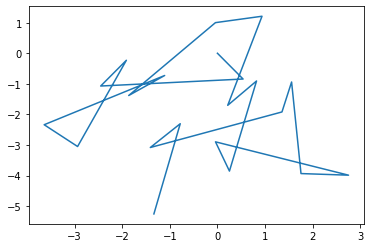

[ 0.          0.9723692  -1.86380241 -1.63018844 -0.24548983 -1.08700315
  1.60385211  0.60850548  0.96669832  1.31237816 -1.5586387  -0.58683733
  0.71125889 -0.11909545  0.9606976   1.38915662  0.53947587  1.46633176
  2.4137078   1.50159448  3.00322576] [ 0.         -0.23344838 -1.2112677  -0.23893827 -2.90025557 -2.36001921
 -3.6864045  -3.78276356 -0.804224   -1.74257652 -0.87236839 -0.63656745
 -3.34118318 -3.89841891 -1.09948216 -2.00304337  0.8741154   1.24953271
 -1.5969526  -1.18701446  1.41011925] -19.862993634612987


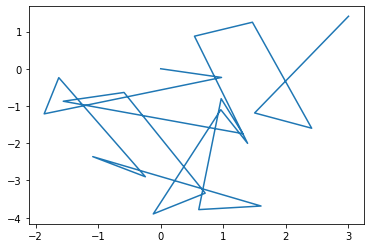

In [52]:
for i in range(0, T, 100):
    plot_path(start_point, history_best_chromosome[i, :], lengths)

In [53]:
d = 20
N = 800
T = 800
start_point = np.array([0, 0])
target = np.array([10, 20])
ranges = np.array([[-90, 90]]*d)
lengths = np.array([1,3] * (d//2))
n_of_p = 1
sigma = 5
k = 1.0
tau = k/np.sqrt(2*d)
tau_0 = k/np.sqrt(2*np.sqrt(d))

best_solution_objective_value, best_solution, history_objective_values, history_best_chromosome, history_best_sigmas = es(
    lambda x: objective_function(x, lengths, start_point, target, ranges=ranges, penalty=None), 
    d, 2*N, T, N, n_of_p, sigma, tau, tau_0, ranges=ranges, log_frequency=50)

Iteration 0000 : best score = -15.13730442, mean score = -22.45782536.
Iteration 0050 : best score = -9.64681006, mean score = -16.01996683.
Iteration 0100 : best score = -9.64681006, mean score = -15.31637115.
Iteration 0150 : best score = -9.64681006, mean score = -15.01008789.
Iteration 0200 : best score = -9.64681006, mean score = -14.82859505.
Iteration 0250 : best score = -9.64681006, mean score = -14.71108659.
Iteration 0300 : best score = -9.64681006, mean score = -14.62709430.
Iteration 0350 : best score = -9.64681006, mean score = -14.55186659.
Iteration 0400 : best score = -9.64681006, mean score = -14.48107857.
Iteration 0450 : best score = -9.64681006, mean score = -14.36672068.
Iteration 0500 : best score = -9.64681006, mean score = -14.28222712.
Iteration 0550 : best score = -9.64681006, mean score = -14.20544675.
Iteration 0600 : best score = -9.64681006, mean score = -14.15224536.
Iteration 0650 : best score = -9.64681006, mean score = -14.09683157.
Iteration 0700 : be

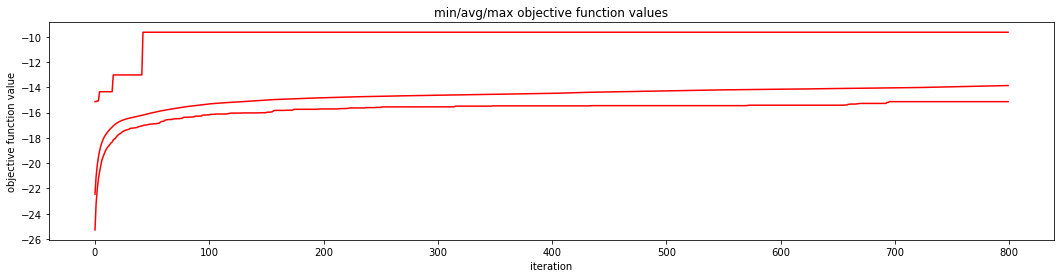

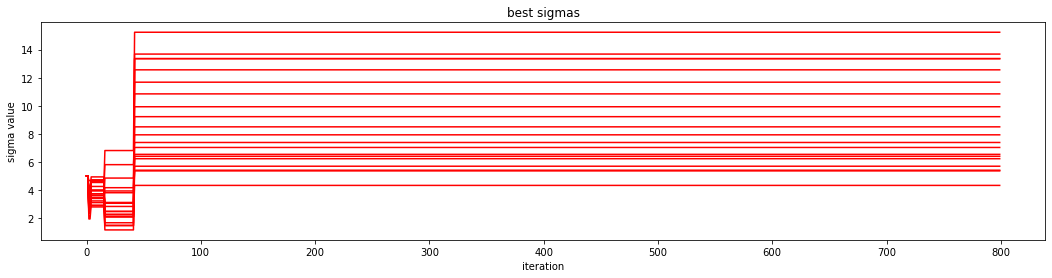

In [54]:
plt.figure(figsize=(18, 4))
plt.plot(history_objective_values[:, 0], 'r-')
plt.plot(history_objective_values[:, 1], 'r-')
plt.plot(history_objective_values[:, 2], 'r-')
plt.xlabel('iteration')
plt.ylabel('objective function value')
plt.title('min/avg/max objective function values')
plt.show()

plt.figure(figsize=(18, 4))
plt.plot(history_best_sigmas, 'r-')
plt.xlabel('iteration')
plt.ylabel('sigma value')
plt.title('best sigmas')
plt.show()

[ 0.          0.93996417 -1.98297967 -1.4341082   0.10233677 -0.89687797
  1.04945592  1.20687863 -1.73517083 -1.40965139  1.21337344  0.44480177
  2.30364436  2.00608889  1.23975024  2.18376443 -0.71107737 -0.42485092
  2.32699554  1.36011514  2.21707853] [ 0.00000000e+00 -3.41273148e-01  3.34300190e-01  1.17020695e+00
 -1.40648411e+00 -1.36686204e+00  9.16071252e-01 -7.14600587e-02
  5.15349099e-01  1.46088445e+00  4.95152086e-03 -6.34812175e-01
  1.71990739e+00  7.65202862e-01  3.66567266e+00  3.33576782e+00
  4.12309936e+00  5.08126136e+00  3.88654755e+00  4.14177746e+00
  7.01677550e+00] -15.137304417165494


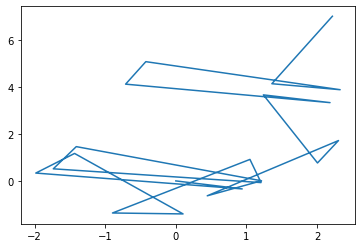

[ 0.          0.99995679 -1.10760716 -0.87954233  0.11526807 -0.75168596
  2.00886017  1.17794659  2.82435745  2.28895636  1.23252149  2.23242293
  2.27454181  1.63955109  4.19559468  3.2948538   2.69867252  3.01180504
  1.36607636  2.20713537 -0.52493324] [ 0.         -0.00929636 -2.14428446 -1.17063851 -4.00089509 -3.50250698
 -2.32803474 -2.88443623 -0.37658231 -1.22118024  1.58665618  1.60069581
 -1.39900851 -0.62648875 -2.19704317 -2.63140001  0.30876459 -0.64094485
  1.86735679  1.32641341  0.08713898] -22.52323808141223


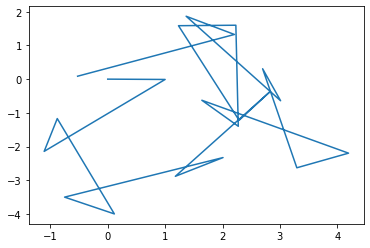

[ 0.          0.99995679 -1.10760716 -0.87954233  0.11526807 -0.75168596
  2.00886017  1.17794659  2.82435745  2.28895636  1.23252149  2.23242293
  2.27454181  1.63955109  4.19559468  3.2948538   2.69867252  3.01180504
  1.36607636  2.20713537 -0.52493324] [ 0.         -0.00929636 -2.14428446 -1.17063851 -4.00089509 -3.50250698
 -2.32803474 -2.88443623 -0.37658231 -1.22118024  1.58665618  1.60069581
 -1.39900851 -0.62648875 -2.19704317 -2.63140001  0.30876459 -0.64094485
  1.86735679  1.32641341  0.08713898] -22.52323808141223


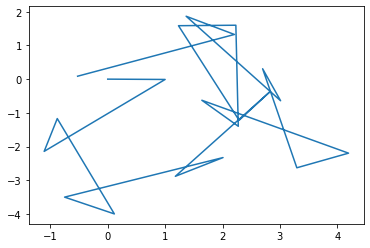

[ 0.          0.99995679 -1.10760716 -0.87954233  0.11526807 -0.75168596
  2.00886017  1.17794659  2.82435745  2.28895636  1.23252149  2.23242293
  2.27454181  1.63955109  4.19559468  3.2948538   2.69867252  3.01180504
  1.36607636  2.20713537 -0.52493324] [ 0.         -0.00929636 -2.14428446 -1.17063851 -4.00089509 -3.50250698
 -2.32803474 -2.88443623 -0.37658231 -1.22118024  1.58665618  1.60069581
 -1.39900851 -0.62648875 -2.19704317 -2.63140001  0.30876459 -0.64094485
  1.86735679  1.32641341  0.08713898] -22.52323808141223


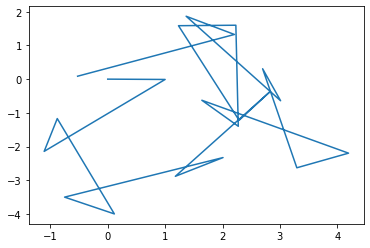

[ 0.          0.99995679 -1.10760716 -0.87954233  0.11526807 -0.75168596
  2.00886017  1.17794659  2.82435745  2.28895636  1.23252149  2.23242293
  2.27454181  1.63955109  4.19559468  3.2948538   2.69867252  3.01180504
  1.36607636  2.20713537 -0.52493324] [ 0.         -0.00929636 -2.14428446 -1.17063851 -4.00089509 -3.50250698
 -2.32803474 -2.88443623 -0.37658231 -1.22118024  1.58665618  1.60069581
 -1.39900851 -0.62648875 -2.19704317 -2.63140001  0.30876459 -0.64094485
  1.86735679  1.32641341  0.08713898] -22.52323808141223


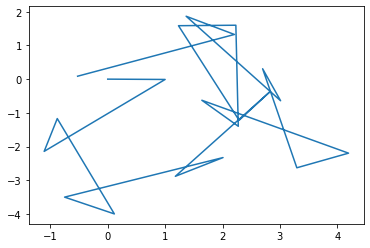

[ 0.          0.99995679 -1.10760716 -0.87954233  0.11526807 -0.75168596
  2.00886017  1.17794659  2.82435745  2.28895636  1.23252149  2.23242293
  2.27454181  1.63955109  4.19559468  3.2948538   2.69867252  3.01180504
  1.36607636  2.20713537 -0.52493324] [ 0.         -0.00929636 -2.14428446 -1.17063851 -4.00089509 -3.50250698
 -2.32803474 -2.88443623 -0.37658231 -1.22118024  1.58665618  1.60069581
 -1.39900851 -0.62648875 -2.19704317 -2.63140001  0.30876459 -0.64094485
  1.86735679  1.32641341  0.08713898] -22.52323808141223


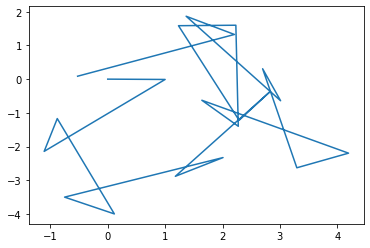

[ 0.          0.99995679 -1.10760716 -0.87954233  0.11526807 -0.75168596
  2.00886017  1.17794659  2.82435745  2.28895636  1.23252149  2.23242293
  2.27454181  1.63955109  4.19559468  3.2948538   2.69867252  3.01180504
  1.36607636  2.20713537 -0.52493324] [ 0.         -0.00929636 -2.14428446 -1.17063851 -4.00089509 -3.50250698
 -2.32803474 -2.88443623 -0.37658231 -1.22118024  1.58665618  1.60069581
 -1.39900851 -0.62648875 -2.19704317 -2.63140001  0.30876459 -0.64094485
  1.86735679  1.32641341  0.08713898] -22.52323808141223


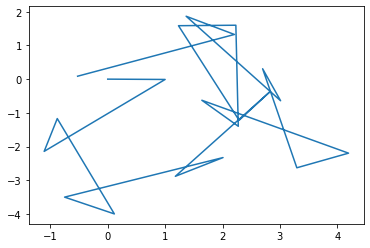

[ 0.          0.99995679 -1.10760716 -0.87954233  0.11526807 -0.75168596
  2.00886017  1.17794659  2.82435745  2.28895636  1.23252149  2.23242293
  2.27454181  1.63955109  4.19559468  3.2948538   2.69867252  3.01180504
  1.36607636  2.20713537 -0.52493324] [ 0.         -0.00929636 -2.14428446 -1.17063851 -4.00089509 -3.50250698
 -2.32803474 -2.88443623 -0.37658231 -1.22118024  1.58665618  1.60069581
 -1.39900851 -0.62648875 -2.19704317 -2.63140001  0.30876459 -0.64094485
  1.86735679  1.32641341  0.08713898] -22.52323808141223


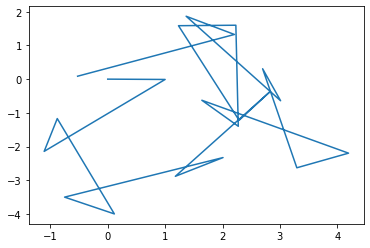

In [55]:
for i in range(0, T, 100):
    plot_path(start_point, history_best_chromosome[i, :], lengths)

In [52]:
test_d = 2
test_size = 10
test_m = np.array([100, 50])
test_C = np.array([[0.5, 0.25], [0.25, 0.25]])
test_sigma = 1
test_m + np.dot(np.random.randn(test_size, test_d), np.linalg.cholesky(test_C).T)
# np.random.multivariate_normal(test_m, test_sigma**2 * test_C,(test_size, test_d))

array([[ 99.37366862,  49.18605544],
       [100.52427365,  50.27564906],
       [100.38505335,  50.56326642],
       [100.19416207,  50.64149033],
       [ 99.58377902,  49.64804592],
       [100.42310017,  50.15269979],
       [ 99.51260377,  49.88873048],
       [100.88039082,  50.23149521],
       [100.86040416,  51.13383999],
       [ 99.88491417,  49.59278386]])

[ 0.0000000e+00  0.0000000e+00 -1.2246468e-16  2.0000000e+00
  2.0000000e+00 -2.0000000e+00 -2.0000000e+00  4.0000000e+00
  4.0000000e+00 -4.0000000e+00 -4.0000000e+00] [ 0.  0. -1. -1.  2.  2. -3. -3.  4.  4. -5.]


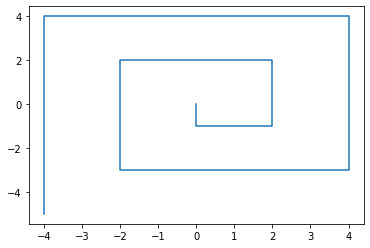

In [41]:
test_start_point = np.array([0,0])
test_angles = np.zeros(10) + 90
test_lengths = np.arange(10)
test_xs, test_ys = gen_points(test_start_point, test_angles, test_lengths)
print(test_xs, test_ys)
plt.plot(test_xs, test_ys)

In [ ]:
# wi = mi - i + 1